### Visualizing the distribution of the observations

### Load the required libraries

In [1]:
sc.stop()

NameError: name 'sc' is not defined

In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
import urllib
import math
%pylab inline

import findspark
findspark.init()

from pyspark import SparkContext
#sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStats.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

import sys
sys.path.append('./lib')

import numpy as np
from numpy_pack import packArray,unpackArray
from spark_PCA import computeCov
from computeStats import computeOverAllDist, STAT_Descriptions

### Read the data frame from pickle file

data_dir='../../Data/Weather'
file_index= 'BSBSSSBB'
# file_index='BBBSBBBB'

from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
print 'keys from STAT=',STAT.keys()

#read data
filename=data_dir+'/US_Weather_%s.parquet'%file_index

df=sqlContext.read.parquet(filename)
print df.count()
df.show(10)

Populating the interactive namespace from numpy and matplotlib
keys from STAT= ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']
13081
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|     36.6| 31.9297| -82.6792|       TMAX|USC00095386|    14|[90 55 A0 56 38 5...|1946.0|BSBSSSBB|
|     36.6| 31.9297| -82.6792|       TMAX|USC00095386|     0|[B0 58 E0 55 B0 5...|1947.0|BSBSSSBB|
|     36.6| 31.9297| -82.6792|       TMAX|USC00095386|     1|[78 5B 98 5A A0 5...|1948.0|BSBSSSBB|
|     36.6| 31.9297| -82.6792|       TMAX|USC00095386|    32|[70 5A 98 5A 48 5...|1950.0|BSBSSSBB|
|     36.6| 31.9297| -82.6792|       TMAX|USC00095386|     7|[00 58 90 59 C8 5...|1951.0|BSBSSSBB|
|     36.6| 31.9297| -82.6792|       TMAX|USC00095386|     9|[D0 5B 14 5C 

In [5]:
print 'The average precipitation', STAT['PRCP']['Mean'].mean()/10

The average precipitation 3.09081085572


### Select data for a particular station and measurement type

In [6]:
sqlContext.registerDataFrameAsTable(df,'weather')
Query="SELECT station, elevation, latitude, longitude, vector, year FROM weather\n\tWHERE measurement='%s'"%('SNWD')
df1 = sqlContext.sql(Query)
rows=df1.rdd.map(lambda row:[unpackArray(row['vector'],np.float16), row['station'], row['elevation'], row['latitude'], row['longitude'], row['year']]).collect()
data = pd.DataFrame(rows, columns=('vector', 'station', 'elevation', 'latitude', 'longitude', 'year'))

In [7]:
data.head()

,vector,station,elevation,latitude,longitude,year
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",USC00095386,36.6,31.9297,-82.6792,1930.0
1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",USC00095386,36.6,31.9297,-82.6792,1931.0
2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",USC00095386,36.6,31.9297,-82.6792,1932.0
3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",USC00095386,36.6,31.9297,-82.6792,1933.0
4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",USC00095386,36.6,31.9297,-82.6792,1934.0


In [8]:
data_with_SNWD = (data['vector'][data['vector'].apply(lambda x: np.nansum(x)) >0].count())*1.0
total_data_size = (data.shape[0])*1.0
print data_with_SNWD/total_data_size *100, '% of total instances have records for SNWD'
data['SNWD_sum'] = data['vector'].apply(lambda x: np.nansum(x))

2.33349538162 % of total instances have records for SNWD


In [9]:
total_data_size

2057.0

In [10]:
data['station'][data['vector'].apply(lambda x: np.nansum(x[32:60])) >0].count() #32
# data['station'][data['vector'].apply(lambda x: np.nansum(x[274:])) >0].count() #16

25

In [11]:
data['SNWD_bin'] = data['SNWD_sum'].apply(lambda x: 1 if x > 0 else 0)

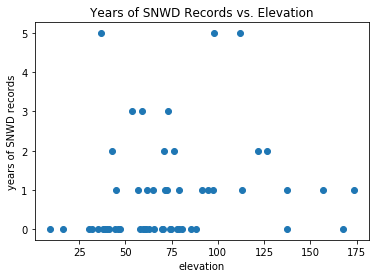

In [12]:
a = data.groupby('elevation')['SNWD_bin'].sum()
plt.scatter(a.index, a.values)
plt.xlabel('elevation')
plt.ylabel('years of SNWD records')
plt.title('Years of SNWD Records vs. Elevation')

In [13]:
sqlContext.registerDataFrameAsTable(df,'weather')
Query="SELECT * FROM weather\n\tWHERE measurement='%s' and station='%s'"%('PRCP','USC00095386')
print Query
df1 = sqlContext.sql(Query)
print df1.count(),'rows'
df1.show(2)
rows=df1.rdd.map(lambda row:unpackArray(row['vector'],np.float16)).collect()
T=np.vstack(rows)
T=T/10.  # scaling to make the temperature be in centingrates
shape(T)

SELECT * FROM weather
	WHERE measurement='PRCP' and station='USC00095386'
72 rows
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|     36.6| 31.9297| -82.6792|       PRCP|USC00095386|     0|[00 00 00 00 00 0...|1910.0|BSBSSSBB|
|     36.6| 31.9297| -82.6792|       PRCP|USC00095386|     2|[00 45 00 00 10 5...|1911.0|BSBSSSBB|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 2 rows



(72, 365)

### Script for plotting yearly plots

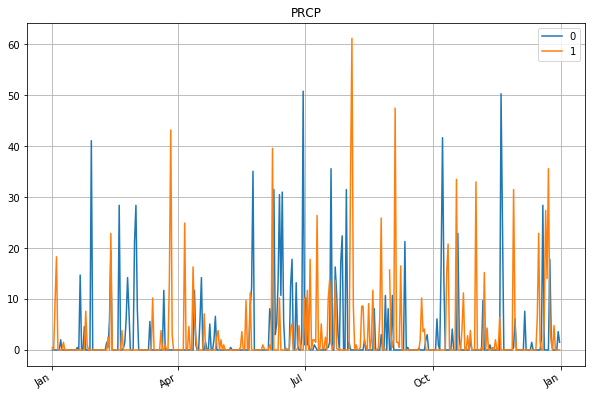

In [14]:
from YearPlotter import YearPlotter
fig, ax = plt.subplots(figsize=(10,7));
YP=YearPlotter()
YP.plot(T[:2,:].transpose(),fig,ax,title='PRCP')
#title('A sample of graphs');

### Distribution of missing observations
The distribution of missing observations is not uniform throughout the year. We visualize it below.

In [15]:
def plot_pair(pair,func):
    j=0
    fig,X=subplots(1,2,figsize=(16,6))
    axes=X.reshape(2)
    for m in pair:
        axis = axes[j]
        j+=1
        func(m,fig,axis)
        
def plot_valid(m,fig,axis):
    valid_m=STAT[m]['NE']
    YP.plot(valid_m,fig,axis,title='valid-counts '+m)
    

/root/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


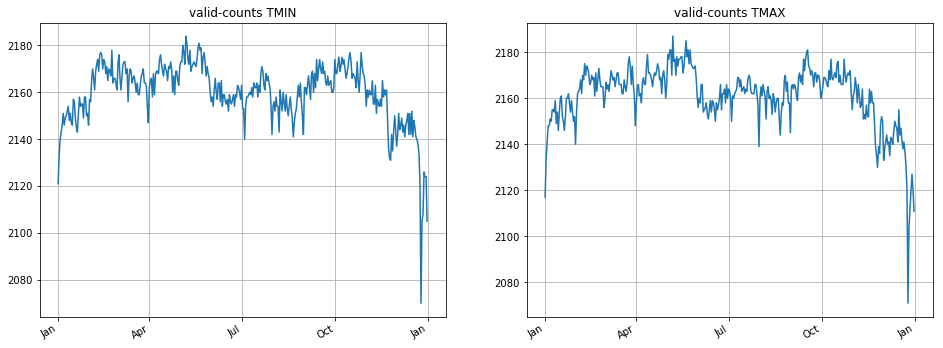

In [16]:
plot_pair(['TMIN','TMAX'],plot_valid)

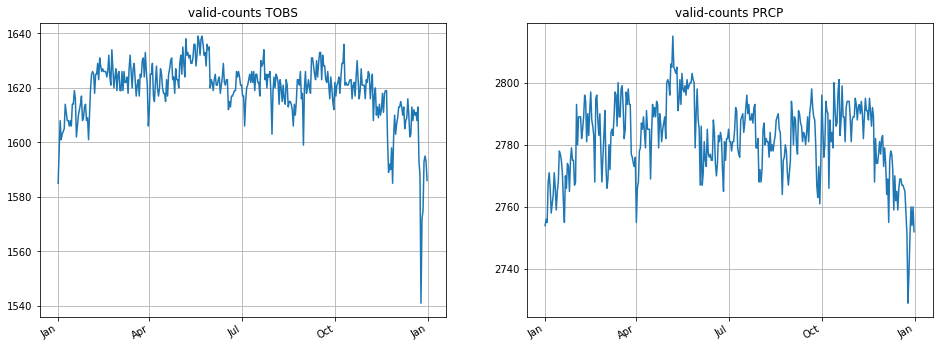

In [17]:
plot_pair(['TOBS','PRCP'],plot_valid)

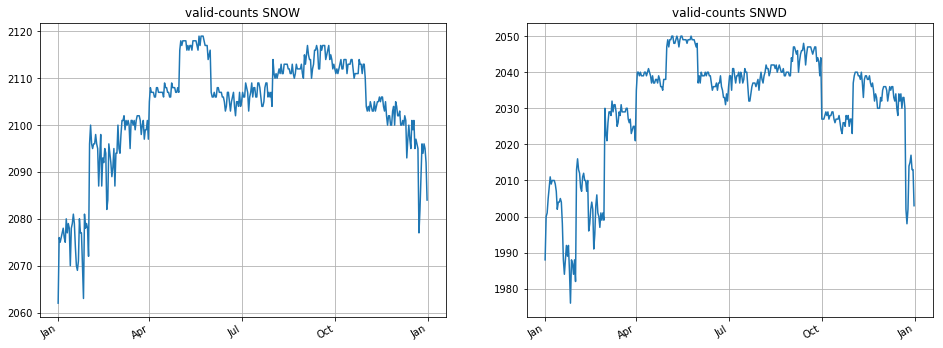

In [18]:
plot_pair(['SNOW', 'SNWD'],plot_valid)

### Plots of mean and std of observations

In [19]:
def plot_mean_std(m,fig,axis):
    mean=STAT[m]['Mean']
    std=np.sqrt(STAT[m]['Var'])
    if m in ["TMAX", "TMIN", "TOBS", "PRCP"]:
        mean = mean/10
        std = std/10
    graphs=np.vstack([mean-std,mean,mean+std]).transpose()
    YP.plot(graphs,fig,axis, xlabel= 'Months', ylabel= 'Degrees in Celsius', labels= ('mean-std', 'mean', 'mean+std'), title='Mean+-std   '+m)

In [20]:
def plot_mean(m,fig,axis):
    mean=STAT[m]['Mean']
    if m in ["TMAX", "TMIN", "TOBS"]:
        mean = mean/10
    graphs=mean.transpose()
    YP.plot(graphs,fig,axis, xlabel= 'Months', ylabel= 'In Millimeters', labels= ('mean'), title='Mean   '+m)

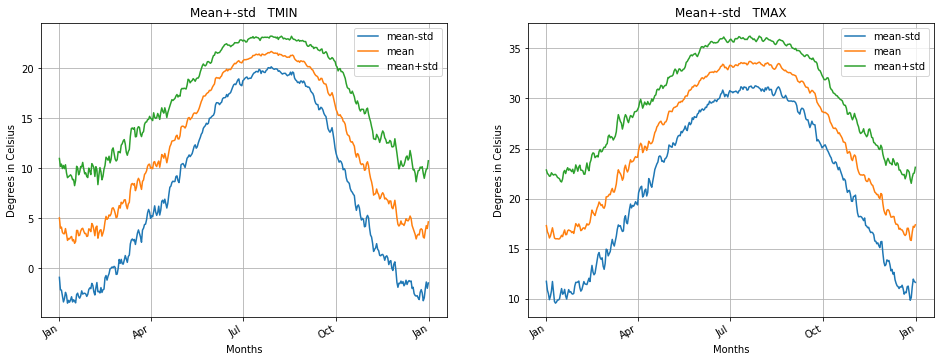

In [21]:
plot_pair(['TMIN','TMAX'],plot_mean_std)

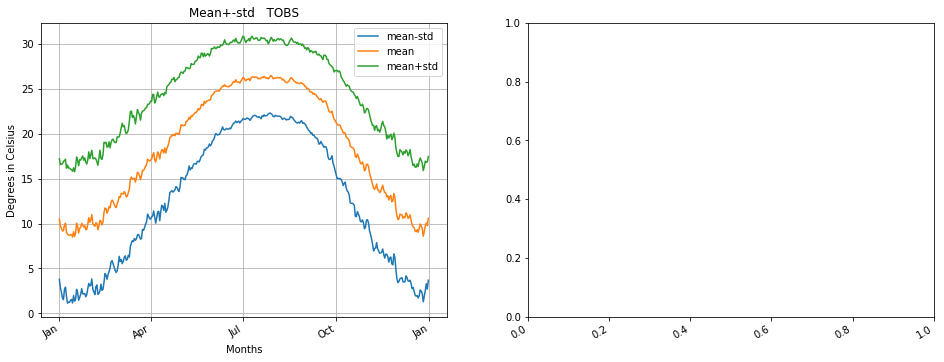

In [22]:
plot_pair(['TOBS'],plot_mean_std)

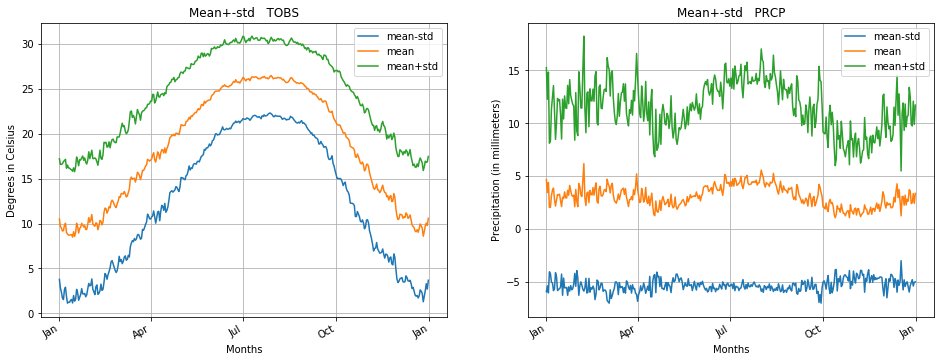

In [23]:
plot_pair(['TOBS','PRCP'],plot_mean_std)
plt.ylabel('Precipitation (in millimeters)')

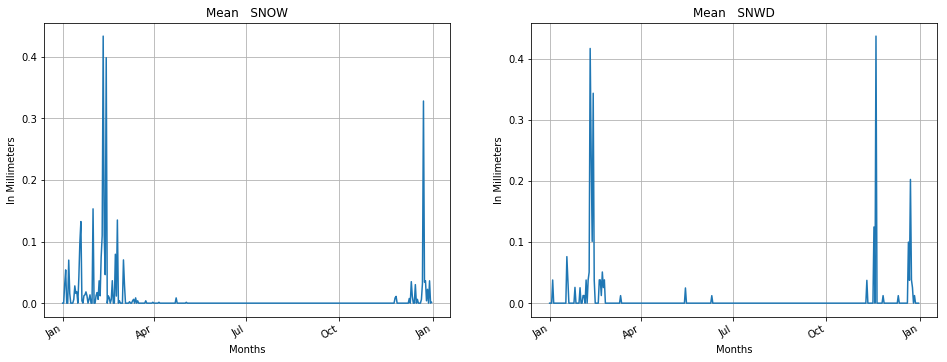

In [87]:
# plot_pair(['SNOW', 'SNWD'],plot_mean_std)
plot_pair(['SNOW', 'SNWD'],plot_mean)

### plotting top 3 eigenvectors

In [94]:
def plot_eigen(m,fig,axis):
    EV=STAT[m]['eigvec']
    YP.plot(EV[:,:3],fig,axis,title='Top Eigenvectors '+m)

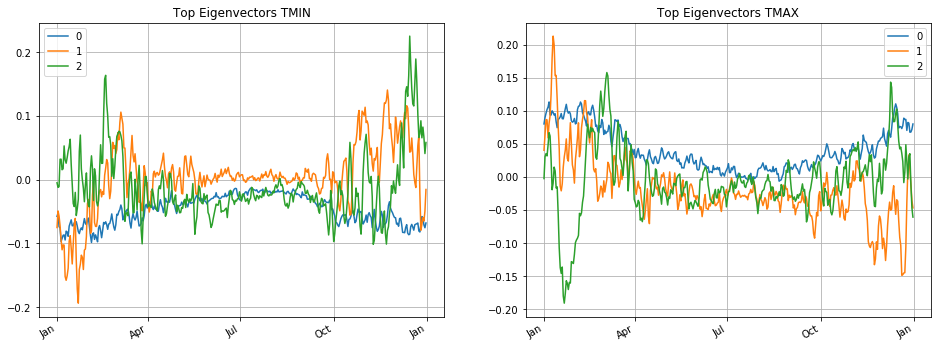

In [95]:
plot_pair(['TMIN','TMAX'],plot_eigen)

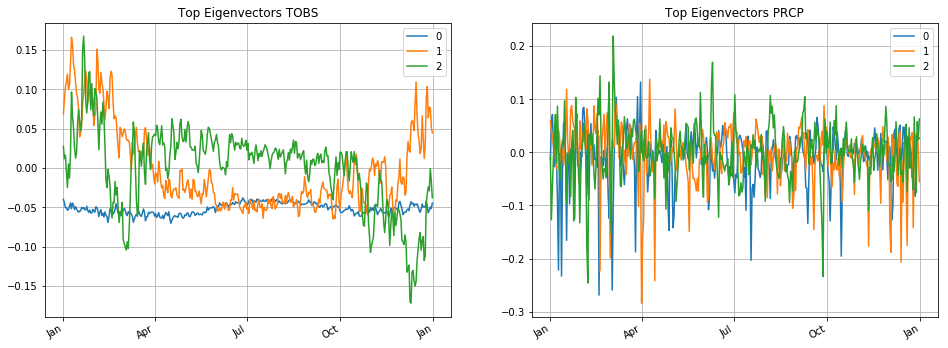

In [96]:
plot_pair(['TOBS','PRCP'],plot_eigen)

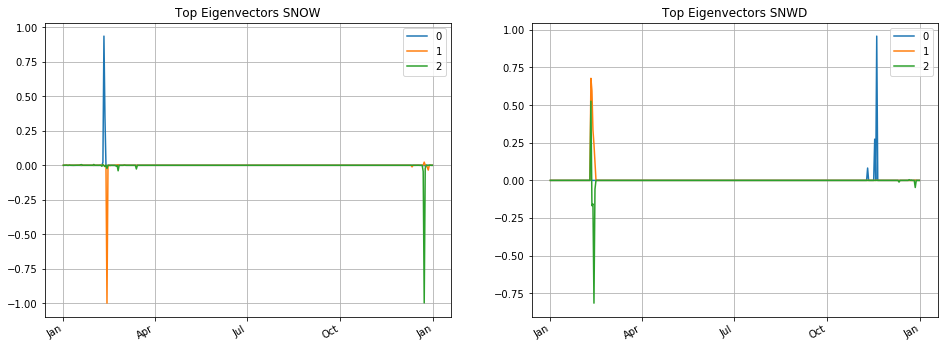

In [97]:
plot_pair(['SNOW', 'SNWD'],plot_eigen)

### Script for plotting percentage of variance explained

In [98]:
def pltVarExplained(j):
    subplot(1,3,j)
    EV=STAT[m]['eigval']
    k=5
    plot(([0,]+list(cumsum(EV[:k])))/sum(EV))
    title('Percentage of Variance Explained for '+ m)
    ylabel('Percentage of Variance')
    xlabel('# Eigenvector')
    grid()
    

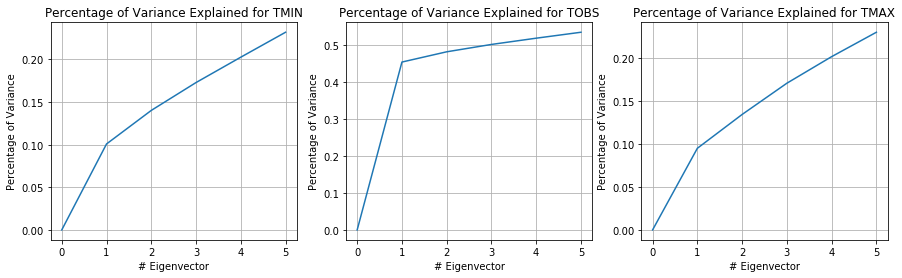

In [99]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['TMIN', 'TOBS', 'TMAX']: #,
    pltVarExplained(j)
    j+=1

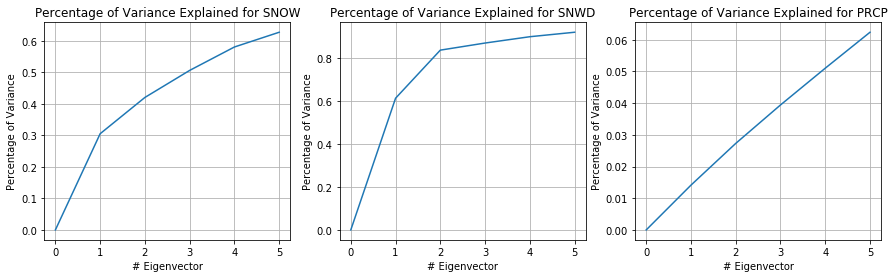

In [100]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['SNOW', 'SNWD', 'PRCP']:
    pltVarExplained(j)
    j+=1 